# 🛰️ Finetuning Pixtral on a satellite imagery dataset 🛰️

TL;DR: This notebook will show you:
- How to call Mistral's **batch inference** API
- How to **pass images** (encoded in base64) **in your API calls** to Mistral's VLM (here Pixtral-12B)
- How to **fine-tune Pixtral-12B** on an image classification problem in order to improve it's accuracy.

For additional references check out the docs:
- https://docs.mistral.ai/capabilities/finetuning/
- https://docs.mistral.ai/capabilities/vision/

In [ ]:
from IPython.display import clear_output
!pip install mistralai
clear_output()

## Prepare the dataset

We will use [AID: A scene classification dataset](https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets) hosted on Kaggle.

To downloading it, you will have to generate your Kaggle API token:
- Go to your Kaggle account in the [Kaggle API Token](https://www.kaggle.com/settings/account) section,
- Click "Create New API Token" → this will download kaggle.json.
- Upload kaggle.json to Google Colab.

## Download and parse the data

In [ ]:
def is_colab_runtime() -> bool:
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [ ]:
if is_colab_runtime():

    from google.colab import files

    # This will prompt you to upload kaggle.json
    print("Please upload your kaggle.json file below:")
    files.upload()
    clear_output()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jiayuanchengala/aid-scene-classification-datasets
# This might take a few minutes
!unzip aid-scene-classification-datasets.zip -d satellite_dataset

clear_output()

The dataset consists in:
- satelite images (jpg files)
- each image belongs to a specific class (e.g. airport, commercial, dense residential, medium residential, park, forest, farmland etc.)

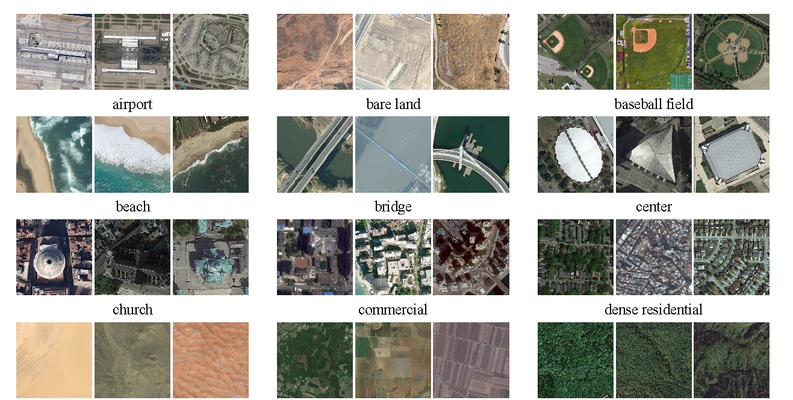


We first transform this dataset into something usable for finetuning
- Create pairs of (image, labels)
- Load the images and encode them in base64 (the format expected by Pixtral API)
- Downgrade the quality of the image in order to be a bit more memory-efficient

In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image
import base64
import io
from sklearn.model_selection import train_test_split

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Extract pairs of (image, label)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

root_dir = Path() / "satellite_dataset" / "AID"
data = []
for d in root_dir.iterdir():
    if not d.is_dir():
        continue
    data.extend([{"label": d.name, "img_path": p} for p in d.iterdir()])

dataset_df = pd.DataFrame(data)
classes = [*dataset_df["label"].unique()]

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Load image and encode in base64 (this might take a few minutes)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# NOTE: This is not needed here, but a nice additional step would be to resize
# the images into 1024 longest edge (if the image was too big)
# For more details see: https://docs.mistral.ai/capabilities/vision/

def encode_image_to_base64(image_path: str | Path) -> str:
    image = Image.open(image_path)

    # Resize the image by a factor of 0.5
    new_size = (image.width // 2, image.height // 2)
    image = image.resize(new_size, Image.Resampling.LANCZOS)

    buffer = io.BytesIO()
    image.save(buffer, format='JPEG')
    buffer.seek(0)

    encoded_string = (
        "data:image/jpeg;base64,"
        + base64.b64encode(buffer.read()).decode('utf-8')
    )

    return encoded_string


dataset_df["img_b64"] = [
    encode_image_to_base64(img_path)
    for img_path in dataset_df["img_path"]
]


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Split dataset in train / test
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

train_df, test_df = train_test_split(
    dataset_df,
    test_size=0.2,
    random_state=42,
    stratify=dataset_df["label"]
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Release a bit of memory
del dataset_df


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Light check at the data
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
print("Classes:", classes)
print("Size train:", len(train_df))
print("Size test:", len(test_df))

train_df.head()

Classes: ['Desert', 'BareLand', 'RailwayStation', 'Mountain', 'Parking', 'River', 'Church', 'MediumResidential', 'Commercial', 'Forest', 'Airport', 'Bridge', 'Park', 'Farmland', 'SparseResidential', 'BaseballField', 'School', 'Playground', 'Square', 'Stadium', 'Meadow', 'Beach', 'Resort', 'DenseResidential', 'Port', 'StorageTanks', 'Pond', 'Viaduct', 'Industrial', 'Center']
Size train: 8000
Size test: 2000


,label,img_path,img_b64
0,Bridge,satellite_dataset/AID/Bridge/bridge_189.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
1,Mountain,satellite_dataset/AID/Mountain/mountain_282.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
2,Park,satellite_dataset/AID/Park/park_66.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
3,Farmland,satellite_dataset/AID/Farmland/farmland_42.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
4,Center,satellite_dataset/AID/Center/center_5.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."



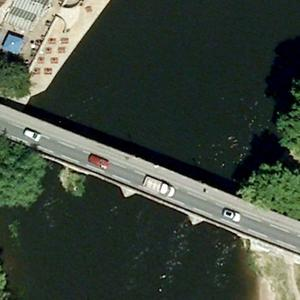


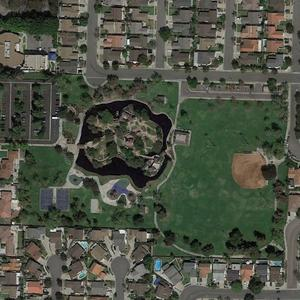

In [ ]:
from IPython.display import display, HTML

def display_image(dataset_df: pd.DataFrame, idx: int) -> None:
    img_b64 = dataset_df["img_b64"].iloc[idx]
    label = dataset_df["label"].iloc[idx]
    display(HTML(f'<h2>{label}</h2><img src="{img_b64}" />'))

display_image(train_df, idx=0)
display_image(train_df, idx=2)

## Prepare a jsonl dataset for Mistral API

In [ ]:
# NOTE: We had to engineer a slighlty complex system prompt as the current
# finetuning of Pixtral-12B (July 2nd 2025) misses a few features that more
# recent models offer:
# - The Classifier Factory in LaPlateforme only supports ministral-3b for now
#   See: https://docs.mistral.ai/capabilities/finetuning/classifier_factory/
# - Structured outputs are not supported by Pixtral-12B

from pydantic import BaseModel

class ClassifierOutput(BaseModel):
    image_description: str
    label: str

instruction_prompt = f"""
Classify the following image into the category it belongs to.
- These category labels are {'; '.join(classes)}.
- Output your result using exclusively the following schema: {ClassifierOutput.model_fields}
- Put your results between a json tag
  ```json
  ```
""".strip()

print("Instruction prompt:")
print(instruction_prompt)

Instruction prompt:
Classify the following image into the category it belongs to.
- These category labels are Desert; BareLand; RailwayStation; Mountain; Parking; River; Church; MediumResidential; Commercial; Forest; Airport; Bridge; Park; Farmland; SparseResidential; BaseballField; School; Playground; Square; Stadium; Meadow; Beach; Resort; DenseResidential; Port; StorageTanks; Pond; Viaduct; Industrial; Center.
- Output your result using exclusively the following schema: {'image_description': FieldInfo(annotation=str, required=True), 'label': FieldInfo(annotation=str, required=True)}
- Put your results between a json tag
  ```json
  ```


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Template functions to generate valid objects according to
# with Mistral's schemas
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

from mistralai.models import UserMessage, SystemMessage, AssistantMessage

def _template_inference_message(
    img_b64: str
) -> list[SystemMessage | UserMessage]:
    return [
        SystemMessage(content=instruction_prompt),
        UserMessage(content=[{"type": "image_url", "image_url": img_b64}])
    ]

def _assistant_message(label: str) -> str:
    return f"""
    ```json
    {{
        "image_description": "An aerial view of a {label.lower()}",
        "label": "{label}"
    }}
    ```

    """.strip()


def _template_finetuning_message(
    img_b64: str, label: str
) -> list[SystemMessage | UserMessage | AssistantMessage]:
    return [
        SystemMessage(content=instruction_prompt),
        UserMessage(content=[{"type": "image_url", "image_url": img_b64}]),
        AssistantMessage(content=_assistant_message(label))
    ]

[SystemMessage(content="Classify the following image into the category it belongs to.\n- These category labels are Desert; BareLand; RailwayStation; Mountain; Parking; River; Church; MediumResidential; Commercial; Forest; Airport; Bridge; Park; Farmland; SparseResidential; BaseballField; School; Playground; Square; Stadium; Meadow; Beach; Resort; DenseResidential; Port; StorageTanks; Pond; Viaduct; Industrial; Center.\n- Output your result using exclusively the following schema: {'image_description': FieldInfo(annotation=str, required=True), 'label': FieldInfo(annotation=str, required=True)}\n- Put your results between a json tag\n  ```json\n  ```", role='system'),
 UserMessage(content=[ImageURLChunk(image_url='', type='image_url')], role='user')]
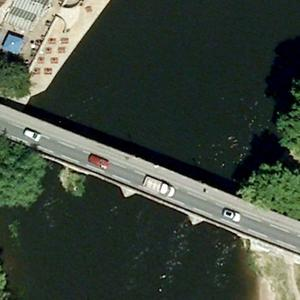

In [ ]:
_template_inference_message(train_df["img_b64"].iloc[0])

[SystemMessage(content="Classify the following image into the category it belongs to.\n- These category labels are Desert; BareLand; RailwayStation; Mountain; Parking; River; Church; MediumResidential; Commercial; Forest; Airport; Bridge; Park; Farmland; SparseResidential; BaseballField; School; Playground; Square; Stadium; Meadow; Beach; Resort; DenseResidential; Port; StorageTanks; Pond; Viaduct; Industrial; Center.\n- Output your result using exclusively the following schema: {'image_description': FieldInfo(annotation=str, required=True), 'label': FieldInfo(annotation=str, required=True)}\n- Put your results between a json tag\n  ```json\n  ```", role='system'),
 UserMessage(content=[ImageURLChunk(image_url='', type='image_url')], role='user'),
 AssistantMessage(content='```json\n    {\n        "image_description": "An aerial view of a bridge",\n        "label": "Bridge"\n    }\n    ```', tool_calls=Unset(), prefix=False, role='assistant')]
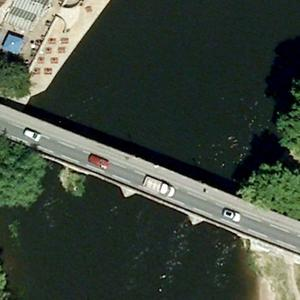

In [ ]:
_template_finetuning_message(train_df["img_b64"].iloc[0], train_df["label"].iloc[0])

{'custom_id': '0',
 'body': {'messages': [{'content': "Classify the following image into the category it belongs to.\n- These category labels are Desert; BareLand; RailwayStation; Mountain; Parking; River; Church; MediumResidential; Commercial; Forest; Airport; Bridge; Park; Farmland; SparseResidential; BaseballField; School; Playground; Square; Stadium; Meadow; Beach; Resort; DenseResidential; Port; StorageTanks; Pond; Viaduct; Industrial; Center.\n- Output your result using exclusively the following schema: {'image_description': FieldInfo(annotation=str, required=True), 'label': FieldInfo(annotation=str, required=True)}\n- Put your results between a json tag\n  ```json\n  ```",
    'role': 'system'},
   {'content': [{'image_url': '',
      'type': 'image_url'}],
    'role': 'user'}]}}
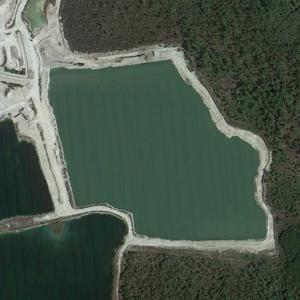

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# We will use the Batch API for inference on the test dataset,
# and thus apply the proper formatting
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

inference_data = []
for row_id, row in test_df.iterrows():
    messages = _template_inference_message(img_b64=row["img_b64"])
    inference_data.append(
        {
            "custom_id": str(row_id),
            "body": {
                "messages": [m.model_dump() for m in messages]
            }
        }
    )

inference_data[0]

[{'content': "Classify the following image into the category it belongs to.\n- These category labels are Desert; BareLand; RailwayStation; Mountain; Parking; River; Church; MediumResidential; Commercial; Forest; Airport; Bridge; Park; Farmland; SparseResidential; BaseballField; School; Playground; Square; Stadium; Meadow; Beach; Resort; DenseResidential; Port; StorageTanks; Pond; Viaduct; Industrial; Center.\n- Output your result using exclusively the following schema: {'image_description': FieldInfo(annotation=str, required=True), 'label': FieldInfo(annotation=str, required=True)}\n- Put your results between a json tag\n  ```json\n  ```",
  'role': 'system'},
 {'content': [{'image_url': '',
    'type': 'image_url'}],
  'role': 'user'},
 {'content': '```json\n    {\n        "image_description": "An aerial view of a bridge",\n        "label": "Bridge"\n    }\n    ```',
  'prefix': False,
  'role': 'assistant'}]
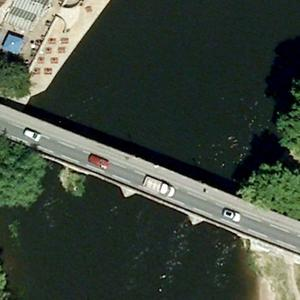

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# We will finetune Pixtral on the train dataset
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
finetuning_data = []
for row_id, row in train_df.iterrows():
    messages = _template_finetuning_message(img_b64=row["img_b64"], label=row["label"])
    finetuning_data.append([m.model_dump() for m in messages])

finetuning_data[0]

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Small util function to convert a dictionnary / JSON into a
# jsonl file for upload to LaPlateforme
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
import json

def dict_to_jsonl(objects: list[dict], path: Path | str) -> None:
    with open(path, 'w') as f:
        for obj in objects:
            f.write(json.dumps(obj) + '\n')

In [ ]:
dict_to_jsonl(inference_data, path=(Path() / "test_satellite_for_batch_inference.jsonl"))
dict_to_jsonl(finetuning_data, path=(Path() / "train_satellite_for_finetuning.jsonl"))

# Classify satellite images using Pixtral-12B

## Get a baseline using the off-the-shelf Pixtral-12B
We will use the "base" Pixtral-12B (no fine-tuning) to get a baseline on this classification task.

In [ ]:
from getpass import getpass
from mistralai import Mistral

api_key= getpass("Type your API Key")
client = Mistral(api_key=api_key)
pixtral = "pixtral-12b-2409"

Type your API Key··········


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Helper function to extract & parse JSON content from the
# model response (it mimics the logic of structured output mode
# which unfortunately is not supported on Pixtral-12B)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

import re
import json

def parse_content(content: str) -> ClassifierOutput | None:
    match = re.search(r'```json\s*(.*?)\s*```', content, re.DOTALL)
    if not match:
        return None

    json_str = match.group(1).strip()
    try:
        return ClassifierOutput(**json.loads(json_str))
    except:
        return None


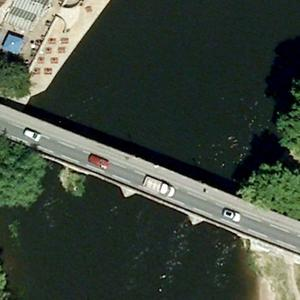

image_description='An aerial view of a bridge over a river with vehicles on it.' label='Bridge'


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# We call the "base" Pixtral-12B on an example that works
# well (right label is retrieved)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
IDX = 0
user_message = _template_inference_message(train_df["img_b64"].iloc[IDX])

results = client.chat.complete(
    model=pixtral,
    messages=user_message,
    temperature=0
)
results = parse_content(results.choices[0].message.content)

display_image(train_df, idx=IDX)
print(results)


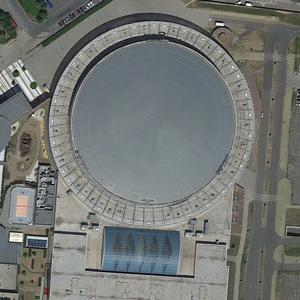

image_description='An aerial view of a large circular structure with a blue roof and surrounding buildings.' label='Church'


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# We call the "base" Pixtral-12B on an example that does not work
# well (wrong label is retrieved)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
IDX = 4
user_message = _template_inference_message(train_df["img_b64"].iloc[IDX])

results = client.chat.complete(
    model=pixtral,
    messages=user_message,
    temperature=0
)
results = parse_content(results.choices[0].message.content)

display_image(train_df, idx=IDX)
print(results)


Since we have many images to caption, we will use Mistral batch API (and might have to wait a little bit)

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Launch a batch inference job
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# NOTE: This can also be done via LaPlateforme UI by drag-and-drop of
# the input files
# NOTE: There might be some size limitation, both in terms of number
# of records and memory footprint of the model

# Upload the dataset
with open(Path() / "test_satellite_for_batch_inference.jsonl", "rb") as f:
    batch_inference_data = client.files.upload(
        file={
            "file_name": "test_satellite_for_batch_inference.jsonl",
            "content": f
        },
        purpose="batch"
    )

# Launch the job
created_job = client.batch.jobs.create(
    input_files=[batch_inference_data.id],
    model=pixtral,
    endpoint="/v1/chat/completions",
    metadata={"job_type": "testing"}
)

print("file ID:", batch_inference_data.id)
print("job ID:", created_job.id)

file ID: 6705b299-2039-4ce2-92ed-e68e7d01170d
job ID: 31358c16-cb01-48ba-acd0-9e8755136ed2


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Util decorator to timeout operations (in case the batch API takes
# longer than expected)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

import signal
from contextlib import contextmanager

class TimeoutException(Exception):
    pass

@contextmanager
def timeout(seconds: int, error_message="Operation timed out"):
    def _handle_timeout(signum, frame):
        raise TimeoutException(error_message)

    # Set the signal handler and an alarm
    signal.signal(signal.SIGALRM, _handle_timeout)
    signal.alarm(seconds)

    try:
        yield
    finally:
        # Cancel the alarm regardless of success or failure
        signal.alarm(0)

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Retrieve job results (with a timeout of 1h)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
import time

with timeout(3600):
    while True:
        retrieved_job = client.batch.jobs.get(job_id=created_job.id)
        if retrieved_job.status not in ["RUNNING", "QUEUED"]:
            print(f"Job finished with status {retrieved_job.status}")
            break

        time.sleep(30)  # Pause for 30s


if not retrieved_job.status == "SUCCESS":
    raise RuntimeError("Batch job failed")

output_file_stream = client.files.download(file_id=retrieved_job.output_file)
results_df = pd.read_json(path_or_buf=output_file_stream, lines=True)
results_df.head()

Job finished with status SUCCESS


,id,custom_id,response,error
0,batch-31358c16-101-0760300a-2759-4668-8a7c-58c...,100,"{'status_code': 200, 'body': {'id': 'adc12251a...",NaN
1,batch-31358c16-102-8f0ccb89-318f-4087-b497-cd5...,101,"{'status_code': 200, 'body': {'id': 'e5e5f2c1c...",NaN
2,batch-31358c16-103-e1f60fdf-15f6-4717-b93f-f1c...,102,"{'status_code': 200, 'body': {'id': 'e573d6761...",NaN
3,batch-31358c16-104-4fc7bdf0-4c3d-4868-86ba-75b...,103,"{'status_code': 200, 'body': {'id': '619ace8d7...",NaN
4,batch-31358c16-105-ca629d7f-5309-44f9-a01b-507...,104,"{'status_code': 200, 'body': {'id': 'bc0140f03...",NaN


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Apply processing to the retrieved results
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
parsed_results_df = results_df.copy()
parsed_results_df[f"predicted_{pixtral}"] = (
    parsed_results_df["response"]
    .apply(lambda response: parse_content(response["body"]["choices"][0]["message"]["content"]))
    .apply(lambda x: x.label if x else None)
)

parsed_results_df = (
    parsed_results_df.sort_values("custom_id")
    .reset_index(drop=True)
    [["custom_id", f"predicted_{pixtral}"]]
)

parsed_results_df.head()

,custom_id,predicted_pixtral-12b-2409
0,0,Pond
1,1,River
2,2,StorageTanks
3,3,Port
4,4,Port


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Let's compare against our "ground_truth"
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
comparison_df = test_df.copy()
comparison_df["custom_id"] = comparison_df.reset_index(drop=False)["index"]
comparison_df = comparison_df.merge(parsed_results_df)
comparison_df.head()

,label,img_path,img_b64,custom_id,predicted_pixtral-12b-2409
0,Pond,satellite_dataset/AID/Pond/pond_119.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",0,Pond
1,River,satellite_dataset/AID/River/river_102.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,River
2,StorageTanks,satellite_dataset/AID/StorageTanks/storagetank...,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",2,StorageTanks
3,Port,satellite_dataset/AID/Port/port_255.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",3,Port
4,Port,satellite_dataset/AID/Port/port_288.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",4,Port


Confusion Matrix:


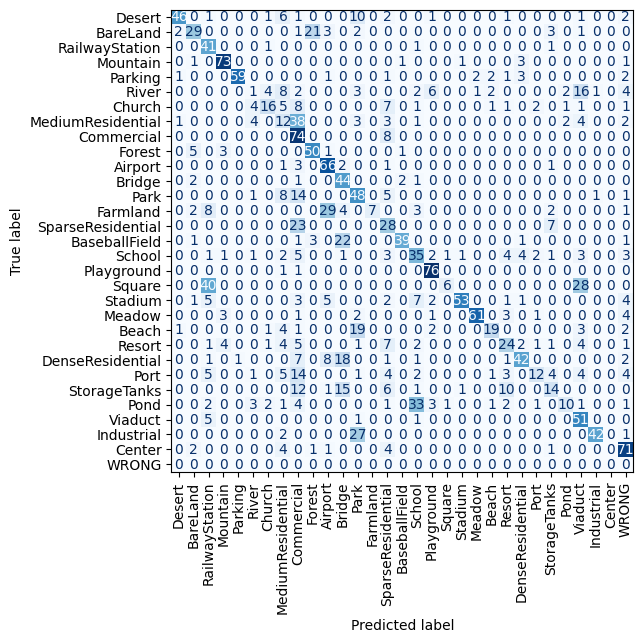

Classification Report:
                   precision    recall  f1-score   support

           Desert       0.90      0.64      0.75        72
         BareLand       0.67      0.47      0.55        62
   RailwayStation       0.37      0.93      0.53        44
         Mountain       0.87      0.91      0.89        80
          Parking       0.98      0.82      0.89        72
            River       0.07      0.02      0.03        52
           Church       0.62      0.33      0.43        48
MediumResidential       0.19      0.17      0.18        70
       Commercial       0.34      0.90      0.49        82
           Forest       0.67      0.83      0.74        60
          Airport       0.57      0.89      0.70        74
           Bridge       0.42      0.88      0.56        50
             Park       0.41      0.62      0.49        78
         Farmland       1.00      0.12      0.22        56
SparseResidential       0.34      0.48      0.40        58
    BaseballField       0.91    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Display traditional classification metrics
# ✅ Good baseline model: some classes are very well handled
#   (e.g. Desert, Railway station, etc.)
# ❌ But there are limitations
#   - some labels are "hallucinated" (i.e. not present in the system prompt)
#   - some classes are not well handled (e.g. River vs. Bridge)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = [*comparison_df["label"]]
y_pred = [
    # NOTE: Pixtral-12B might have hallucinated some categories
    # We'll put them under the "WRONG" label
    label if label in classes else "WRONG"
    for label in comparison_df[f"predicted_{pixtral}"]
]


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Confusion matrix
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*classes, "WRONG"])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.xticks(rotation=90)
plt.show()

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Classification report
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[*classes, "WRONG"]))

## Improve the results by finetuning a Pixtral-12B
*Note: Here the objective of the finetuning is to improve the classification accuracy of the VLM. Finetuning can also be helpful to align the tone of the assistant to a desired style*

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Launch a finetuning job
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# NOTE: This can also be done via LaPlateforme UI by drag-and-drop of
# the input files
# NOTE: There might be some size limitation, both in terms of number
# of records and memory footprint of the model

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Upload your training dataset
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

with open(Path() / "train_satellite_for_finetuning.jsonl", "rb") as f:
    finetuning_data = client.files.upload(
        file={
            "file_name": "train_satellite_for_finetuning.jsonl",
            "content": f
        },
        purpose="fine-tune"
    )

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Create the job
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#
# Fine-tuning is both an art and a science
#
# Our recommended approach for fine-tuning our models is to do so iteratively.
# Start with smaller dataset e.g 200-1000 examples (and potentially smaller
# models), larger learning rates, lower epochs and once you start to see the
# desired results in the correct direction start scaling these to be bigger
# and bigger.
#
# Once you are somewhat comfortable with the fine-tuning data used for the
# model, you want to start playing around with the different fine-tuning
# hyperparameters.
#
# Learning Rate - The learning rate defines how much the model adjusts for each
# training step. Bigger learning rates will make the model move faster so you
# potentially may need less training time, however it may also potentially
# overshoot and reach a local minima
#
# Epochs - This is the amount of full runs across the whole dataset the training
# will do. It’s somewhat proportional to the training time.
#
# Batch Size - This is the number of examples passed in each gradient step to
# updates the FT-weights. A higher batch size typically leads to smoother
# training, but with small datasets you typically use a smaller batch size.
#
# Here is an equation that summarize the relationship between the parameters:
# Epochs = Steps × Batch Size​ / Total Number of Training Samples

created_job = client.fine_tuning.jobs.create(
    model="pixtral-12b-latest",
    training_files=[{"file_id": finetuning_data.id, "weight": 1}],
    validation_files=[],
    hyperparameters={
        "epochs": 1,
        "learning_rate": 0.0001,
    },
    auto_start=True  # This could be set to False to let you manually validate the run
)


print("file ID:", finetuning_data.id)
print("job ID:", created_job.id)

file ID: cbfd90ac-0ff2-4620-8df0-ceb8c199edba
job ID: 9def64f2-fc63-435c-80ee-c3fac35dff8b


In [ ]:
with timeout(3600):
    while True:
        retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
        if retrieved_job.status not in ["VALIDATING", "RUNNING", "QUEUED"]:
            print(f"Job finished with status {retrieved_job.status}")
            break

        time.sleep(30)  # Pause for 30s

Job finished with status SUCCESS


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# See all the details associated with a finetuning job
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
retrieved_job

CompletionDetailedJobOut(id='9def64f2-fc63-435c-80ee-c3fac35dff8b', auto_start=True, model='pixtral-12b-latest', status='SUCCESS', created_at=1751532719, modified_at=1751533075, training_files=['cbfd90ac-0ff2-4620-8df0-ceb8c199edba'], hyperparameters=CompletionTrainingParameters(training_steps=35, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.05, epochs=1.0, seq_len=32768, fim_ratio=None), validation_files=[], object='job', fine_tuned_model='ft:pixtral-12b-latest:d3417809:20250703:9def64f2', suffix=None, integrations=[], trained_tokens=4587520, metadata=JobMetadataOut(expected_duration_seconds=1715, cost=8.94, cost_currency='USD', train_tokens_per_step=127677, train_tokens=4468728, data_tokens=4468728, estimated_start_time=None), job_type='completion', repositories=[], events=[EventOut(name='status-updated', created_at=1751532719, data={'status': 'QUEUED'}), EventOut(name='status-updated', created_at=1751532723, data={'status': 'VALIDATING'}), EventOut(name='status-updated'

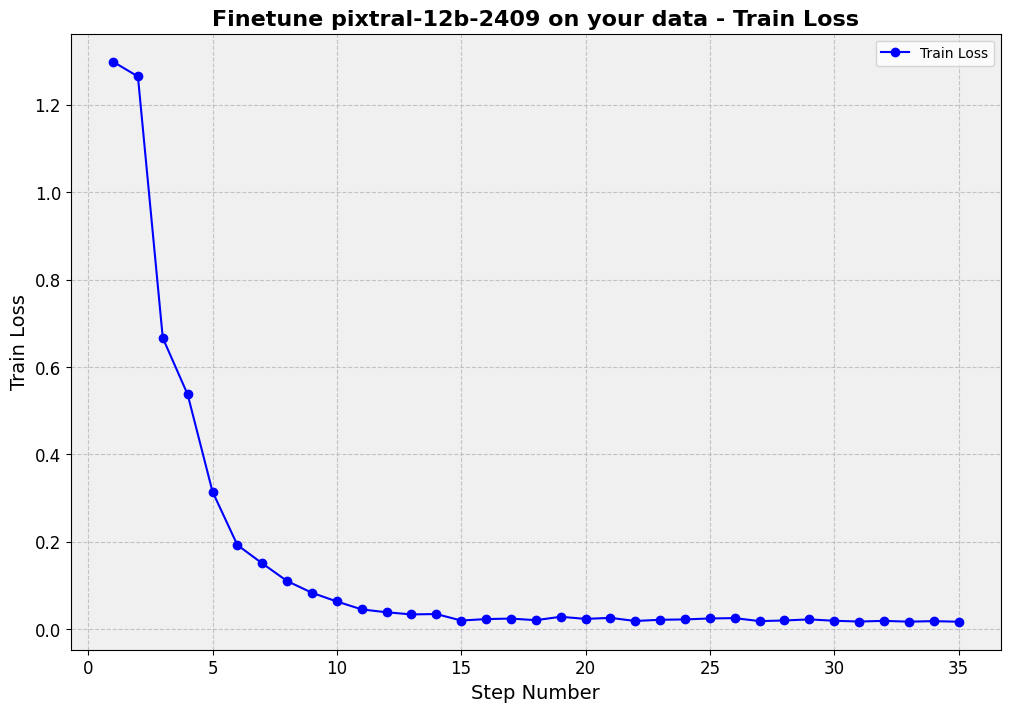

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Visualize the evolution of the loss during FT
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
def plot_loss(job_id: str, model: str) -> None:
    # Extract step_number and train_loss from the job data
    retrieved_job = client.fine_tuning.jobs.get(job_id=job_id)
    step_numbers = [checkpoint.step_number for checkpoint in retrieved_job.checkpoints]
    train_losses = [checkpoint.metrics.train_loss for checkpoint in retrieved_job.checkpoints]

    # Plot the data
    plt.figure(figsize=(12, 8))
    plt.plot(step_numbers, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')

    # Adding titles and labels
    plt.title(f'Finetune {model} on your data - Train Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Train Loss', fontsize=14)

    # Adding grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adding legend
    plt.legend(loc='best')

    # Customizing the appearance
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Adding a background color
    plt.gca().set_facecolor('#f0f0f0')

    # Display the plot
    plt.show()

plot_loss(job_id=retrieved_job.id, model=pixtral)

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Retrieve the ID of the fine-tuned model
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
fine_tuned_pixtral = client.fine_tuning.jobs.get(job_id=created_job.id).fine_tuned_model
fine_tuned_pixtral

'ft:pixtral-12b-latest:d3417809:20250703:9def64f2'

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Make a batch inference with fine-tuned model
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

created_job = client.batch.jobs.create(
    input_files=[batch_inference_data.id],
    model=fine_tuned_pixtral,
    endpoint="/v1/chat/completions",
    metadata={"job_type": "testing"}
)

print("file ID:", batch_inference_data.id)
print("job ID:", created_job.id)

with timeout(3600):
    while True:
        retrieved_job = client.batch.jobs.get(job_id=created_job.id)
        if retrieved_job.status not in ["RUNNING", "QUEUED"]:
            print(f"Job finished with status {retrieved_job.status}")
            break

        time.sleep(30)  # Pause for 30s


if not retrieved_job.status == "SUCCESS":
    raise RuntimeError("Batch job failed")

output_file_stream = client.files.download(file_id=retrieved_job.output_file)
results_df = pd.read_json(path_or_buf=output_file_stream, lines=True)
results_df.head()

file ID: 6705b299-2039-4ce2-92ed-e68e7d01170d
job ID: d49049a4-565e-4ad1-8877-6997ec79e4b0
Job finished with status SUCCESS


,id,custom_id,response,error
0,batch-d49049a4-201-72be39a2-6c51-4025-a995-ebc...,200,"{'status_code': 200, 'body': {'id': '5732e568b...",NaN
1,batch-d49049a4-202-e9166b7b-935e-43df-aaca-b1e...,201,"{'status_code': 200, 'body': {'id': '641e730b1...",NaN
2,batch-d49049a4-203-297e09b9-5883-4b29-bee0-03e...,202,"{'status_code': 200, 'body': {'id': '4aa58b1e4...",NaN
3,batch-d49049a4-204-1de92043-ae06-4d3f-b44c-9b1...,203,"{'status_code': 200, 'body': {'id': '1b0782408...",NaN
4,batch-d49049a4-205-fbd8bf09-18d7-409c-8b7b-13a...,204,"{'status_code': 200, 'body': {'id': 'a49ca906b...",NaN


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Apply processing to the retrieved results (same as previously)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
parsed_results_df = results_df.copy()
parsed_results_df[f"predicted_{fine_tuned_pixtral}"] = (
    parsed_results_df["response"]
    .apply(lambda response: parse_content(response["body"]["choices"][0]["message"]["content"]))
    .apply(lambda x: x.label if x else None)
)

parsed_results_df = (
    parsed_results_df.sort_values("custom_id")
    .reset_index(drop=True)
    [["custom_id", f"predicted_{fine_tuned_pixtral}"]]
)

parsed_results_df.head()

,custom_id,predicted_ft:pixtral-12b-latest:d3417809:20250703:9def64f2
0,0,Pond
1,1,Bridge
2,2,StorageTanks
3,3,Port
4,4,Port


In [ ]:
model_comparison_df = comparison_df.merge(parsed_results_df)
model_comparison_df.head()

,label,img_path,img_b64,custom_id,predicted_pixtral-12b-2409,predicted_ft:pixtral-12b-latest:d3417809:20250703:9def64f2
0,Pond,satellite_dataset/AID/Pond/pond_119.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",0,Pond,Pond
1,River,satellite_dataset/AID/River/river_102.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,River,Bridge
2,StorageTanks,satellite_dataset/AID/StorageTanks/storagetank...,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",2,StorageTanks,StorageTanks
3,Port,satellite_dataset/AID/Port/port_255.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",3,Port,Port
4,Port,satellite_dataset/AID/Port/port_288.jpg,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",4,Port,Port


Confusion Matrix:


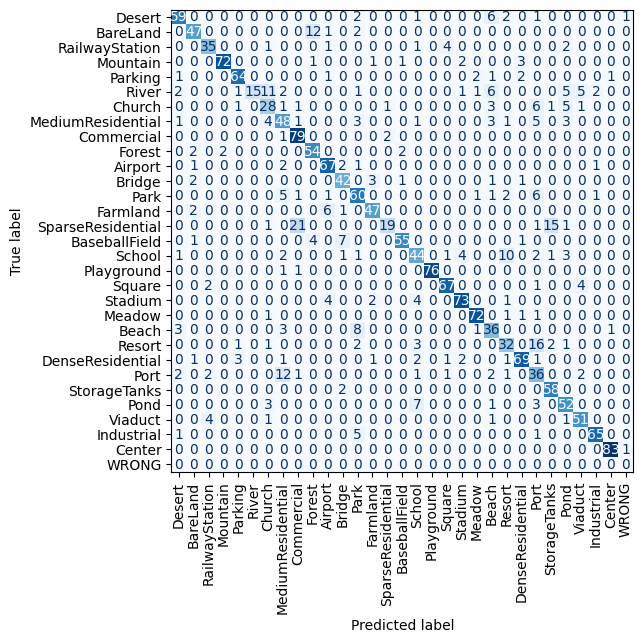

Classification Report:
                   precision    recall  f1-score   support

           Desert       0.84      0.82      0.83        72
         BareLand       0.84      0.76      0.80        62
   RailwayStation       0.81      0.80      0.80        44
         Mountain       0.97      0.90      0.94        80
          Parking       0.91      0.89      0.90        72
            River       1.00      0.29      0.45        52
           Church       0.55      0.58      0.57        48
MediumResidential       0.62      0.69      0.65        70
       Commercial       0.75      0.96      0.84        82
           Forest       0.76      0.90      0.82        60
          Airport       0.83      0.91      0.86        74
           Bridge       0.76      0.84      0.80        50
             Park       0.71      0.77      0.74        78
         Farmland       0.87      0.84      0.85        56
SparseResidential       0.86      0.33      0.47        58
    BaseballField       0.93    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Get classification metrics on the new model
# 🎉 🎉 🎉 Good news: performance are improved:
#   - overall accuracy improvement (from ~0.5 to ~0.8)
#   - almost no more hallucination
#   - huge performance gain on some classes
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = [*model_comparison_df["label"]]
y_pred = [
    # NOTE: Pixtral-12B might have hallucinated some categories
    # We'll put them under the "WRONG" label
    label if label in classes else "WRONG"
    for label in model_comparison_df[f"predicted_{fine_tuned_pixtral}"]
]


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Confusion matrix
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*classes, "WRONG"])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.xticks(rotation=90)
plt.show()

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Classification report
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[*classes, "WRONG"]))

## Wrapping up: Finetuning Pixtral-12B really improves its classification accuracy

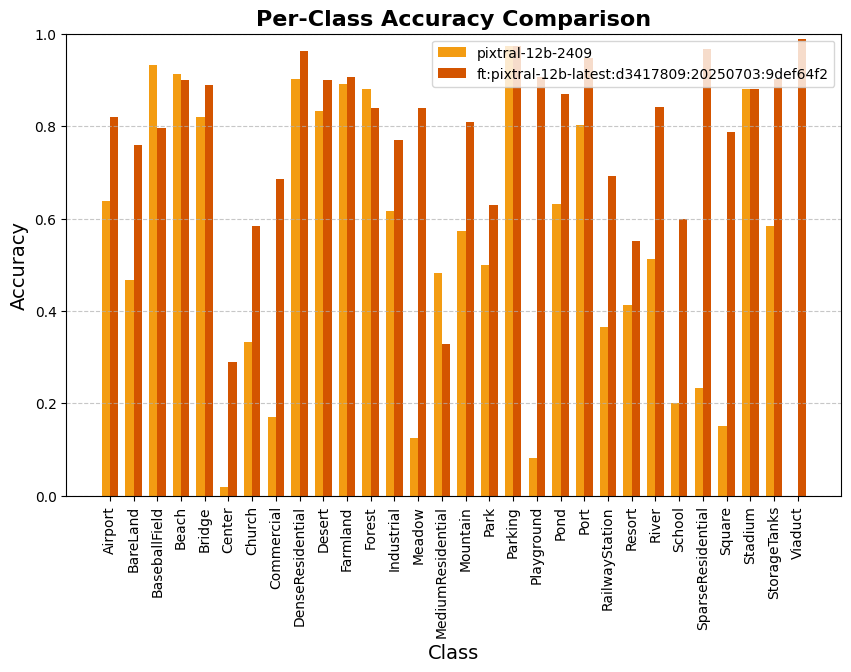

In [ ]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Compare the two models:
# - Huge performance gain on some classes
# - A few classes see a small drop in performance, but overall
#   model performance is improved
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def per_class_accuracy(y_true, y_pred, classes):
    accuracies = []
    for cls in classes:
        idx = np.where(np.array(y_true) == cls)[0]
        if len(idx) == 0:
            accuracies.append(np.nan)
        else:
            acc = accuracy_score(np.array(y_true)[idx], np.array(y_pred)[idx])
            accuracies.append(acc)
    return accuracies


y_true = model_comparison_df["label"]
y_pred_pixtral = model_comparison_df[f"predicted_{pixtral}"]
y_pred_ft_pixtral = model_comparison_df[f"predicted_{fine_tuned_pixtral}"]
classes = sorted(set(y_true))

# Compute per-class accuracy
acc_pixtral = per_class_accuracy(y_true, y_pred_pixtral, classes)
acc_ft_pixtral = per_class_accuracy(y_true, y_pred_ft_pixtral, classes)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# Plotting
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, acc_pixtral, width, label=pixtral, color='#F39C12')
bars2 = ax.bar(x + width/2, acc_ft_pixtral, width, label=fine_tuned_pixtral, color='#D35400')

ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Per-Class Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.0)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()
